Produces a summary of the intensity statistics for the FUCCI dataset as specified in the config file.
Plots PCAs for the images, colored by each well and scope. Also plots PCAs for the average intensity of each well.
Then, it writes a sorted list of the image directories to a pickle file, to be used by other scripts as well.

It also creates PCA plots of the well- and image-level intensity distributions for each microscope in the dataset.
This is primarily useful in designing useful training splits for the pseudotime models down the line.

In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
from config import FUCCI_DS_PATH, HPA_DS_PATH, OUTPUT_DIR
from HPA_CC.data.dataset import DatasetFS
from dataset_summary import load_fucci_wells, load_fucci_percentiles, load_hpa_wells, load_hpa_percentiles, well_percentile_averages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Datasets and Overview of Microscopes/Wells/Images

In [17]:

fucci_ds = DatasetFS(FUCCI_DS_PATH)
hpa_ds = DatasetFS(HPA_DS_PATH)

well_type_dict = {}

for f in fucci_ds.well_list:
    well_type = f.name.split('--')[0]
    if not well_type in well_type_dict:
        well_type_dict[well_type] = []
    well_type_dict[well_type].append(len(list(filter(lambda d: d.is_dir(), f.iterdir()))))

well_type_dict["hpa"] = []
for f in hpa_ds.well_list:
    well_type_dict["hpa"].append(len(list(filter(lambda d: d.is_dir(), f.iterdir()))))
    num_images = len(list(filter(lambda d: d.is_dir(), f.iterdir())))

print("Number of images per well, grouped by microscope/run")
for scope, well_img_cts in well_type_dict.items():
    print(scope)
    print(f"\tNumber of wells: {len(well_img_cts)}")
    print(f"\tTotal number of images: {np.sum(well_img_cts)}")
    print(f"\tMean number of images per well: {np.mean(well_img_cts):.1f}")
    print(f"\t{well_img_cts}")

Number of images per well, grouped by microscope/run
chamber
	Number of wells: 94
	Total number of images: 1001
	Mean number of images per well: 10.6
	[6, 16, 9, 9, 13, 9, 6, 7, 15, 11, 9, 11, 11, 9, 11, 5, 11, 16, 15, 10, 16, 15, 12, 13, 13, 5, 6, 6, 5, 2, 9, 6, 5, 15, 16, 14, 7, 15, 11, 16, 12, 16, 9, 16, 13, 12, 13, 15, 8, 15, 12, 10, 16, 6, 14, 15, 13, 14, 15, 15, 10, 15, 16, 5, 14, 15, 3, 7, 13, 13, 14, 9, 5, 15, 10, 8, 5, 6, 6, 3, 6, 10, 6, 8, 6, 8, 7, 7, 14, 12, 12, 12, 16, 10]
overview1
	Number of wells: 7
	Total number of images: 125
	Mean number of images per well: 17.9
	[2, 4, 26, 43, 40, 7, 3]
tilescan1
	Number of wells: 33
	Total number of images: 1064
	Mean number of images per well: 32.2
	[7, 23, 37, 32, 27, 41, 35, 38, 29, 16, 47, 43, 30, 48, 16, 30, 24, 16, 35, 24, 44, 48, 48, 48, 46, 28, 37, 32, 20, 30, 32, 29, 24]
tilescan2
	Number of wells: 2
	Total number of images: 34
	Mean number of images per well: 17.0
	[3, 31]
hpa
	Number of wells: 69
	Total number of images: 

# Calculate Image Intensity Percentile Profiles and Aggregate by Well

In [18]:
fucci_nuc_percentiles, fucci_mt_percentiles, fucci_cdt1_percentiles, fucci_gmnn_percentiles = load_fucci_percentiles()
hpa_nuc_percentiles, hpa_mt_percentiles, hpa_er_percentiles = load_hpa_percentiles()
fucci_microscopes, fucci_wells = load_fucci_wells()
hpa_microscopes, hpa_wells = load_hpa_wells()

In [19]:
microscopes = list(fucci_microscopes) + list(hpa_microscopes)
wells = list(fucci_wells) + list(hpa_wells)

nuc_percentiles = np.concatenate((fucci_nuc_percentiles, hpa_nuc_percentiles), axis=0)
mt_percentiles = np.concatenate((fucci_mt_percentiles, hpa_mt_percentiles), axis=0)

ref_intensities = np.concatenate((nuc_percentiles, mt_percentiles), axis=1)
well_averages, well_scopes = well_percentile_averages(wells, microscopes, ref_intensities)

# Take PCA and Prep Dataframes for Plotting

In [20]:
pca = PCA(n_components=3)
scaler = StandardScaler()
ref_int_pca = pca.fit_transform(scaler.fit_transform(ref_intensities))
print(f"Explained variance ratio for Reference Intensities: {pca.explained_variance_ratio_}")
well_averages = pca.fit_transform(scaler.fit_transform(np.array(well_averages)))
print(f"Explained variance ratio for Well Avg Intensities: {pca.explained_variance_ratio_}")

Explained variance ratio for Reference Intensities: [0.45204132 0.29608554 0.13493377]
Explained variance ratio for Well Avg Intensities: [0.43133212 0.28082331 0.14971466]


In [21]:
pca_img_ref_int_df = pd.DataFrame({"PC1": ref_int_pca[:, 0], "PC2": ref_int_pca[:, 1], "microscope": microscopes})
pca_well_ref_int_df = pd.DataFrame({"PC1": ref_int_pca[:, 0], "PC2": ref_int_pca[:, 1], "well_nums": wells})
pca_well_avg_df = pd.DataFrame({"PC1": well_averages[:, 0], "PC2": well_averages[:, 1], "scope": well_scopes})

# Figures

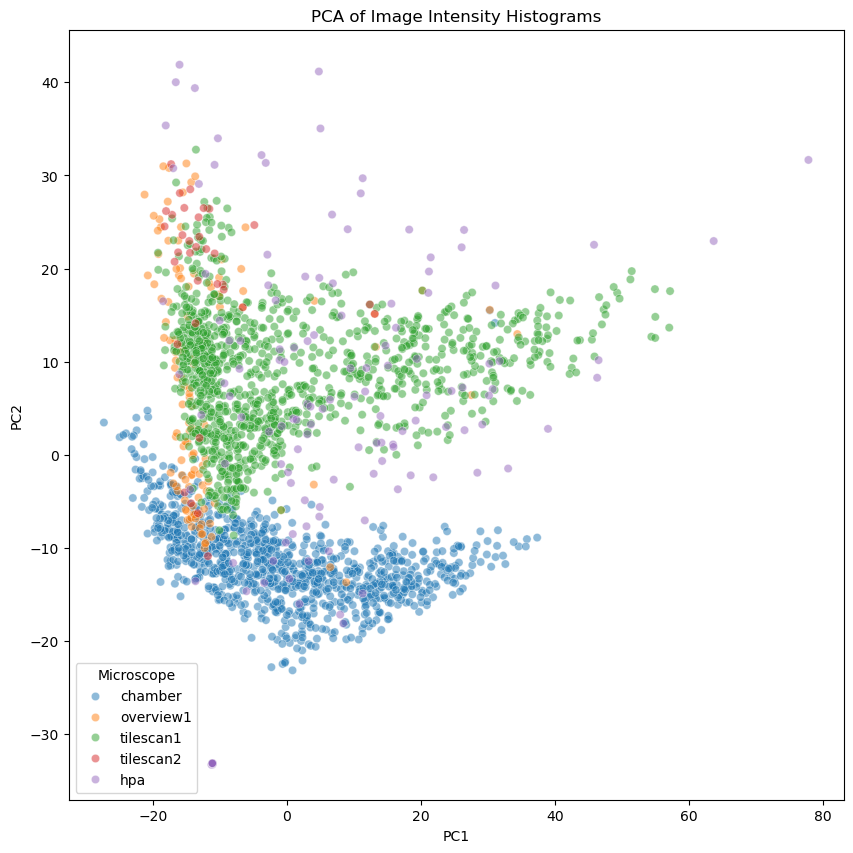

<Figure size 640x480 with 0 Axes>

In [22]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x="PC1", y="PC2", hue="microscope", data=pca_img_ref_int_df, alpha=0.5)
plt.title("PCA of Image Intensity Histograms")
plt.legend(title="Microscope")
plt.show()
plt.clf()

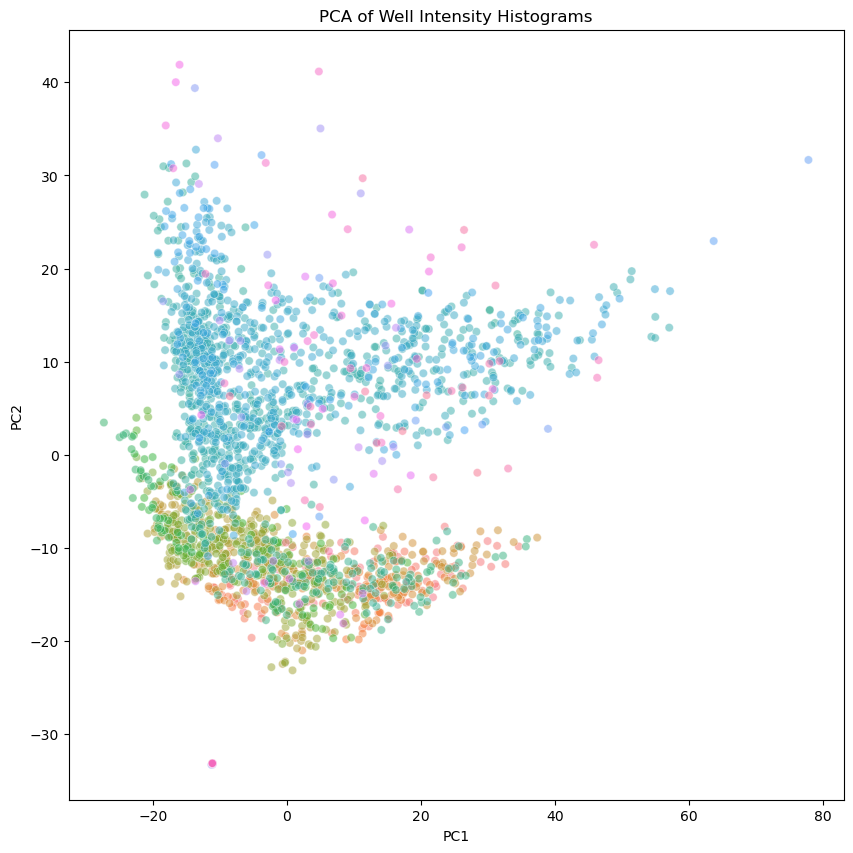

<Figure size 640x480 with 0 Axes>

In [23]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x="PC1", y="PC2", hue="well_nums", data=pca_well_ref_int_df, alpha=0.5, legend=False)
plt.title("PCA of Well Intensity Histograms")
plt.show()
plt.clf()

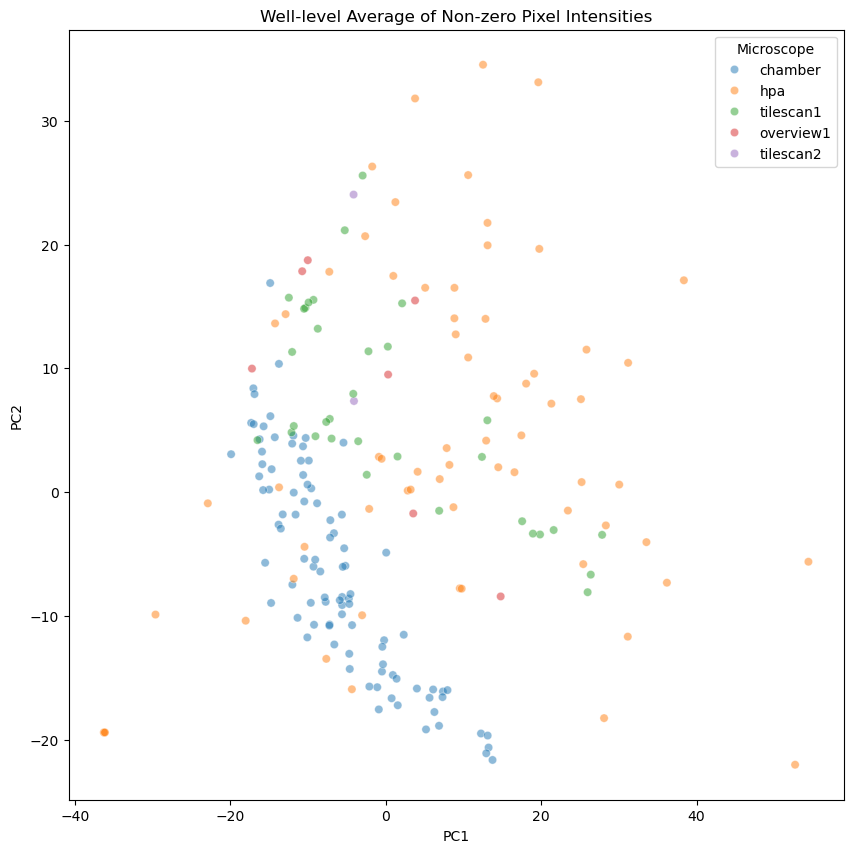

<Figure size 640x480 with 0 Axes>

In [24]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x="PC1", y="PC2", hue="scope", data=pca_well_avg_df, alpha=0.5)
plt.title("Well-level Average of Non-zero Pixel Intensities")
plt.legend(title="Microscope")
plt.show()
plt.clf()

# Conclusions

- The HPA data is mostly similar to the Tilescan1/2 data, with a minority being closer to Chamber and a significant number of wells that are out of distribution wrt the FUCCI dataset
- Note that the FUCCI dataset has the opposite "class balance" in terms of the intensity distributions of the wells
- However the total number of images is about even between the two groups
- So we might guess that Tilescan may potentially have less diversity in the images, but from the PCA it looks like it actually covers a broader distribution